# Deep Reinforced Learning in Action

In meinem letzten Blog habe ich die Grundlagen des Deep Reinforced Learning (aka Q -Leraning oder DQN) beleuchtet und gezeigt, wie ein Computer ein für ihn völlig fremdes Spiel erlernen kann, ohne die Spielregeln zu kennen. Dreh- und Angelpunkt dafür ist die Bellman Gleichung:

![Abb 0: Bellman Gleichung](Bellman.png)

Mit der Gleichung ist man in der Lage, Erfahrungen, die der Computer während des Lernens machte, quasi mitzuschreiben und mir in jeder (Spiel - ) Situation zu sagen, was die vielversprechendste nächste Aktion ist. 

In diesem Blog möchte ich nun an einem einfachen Beispiel zeigen, wie man die Bellman Gleichung in Python Code gießt, damit der Computer lernt, ein einfaches Spiel zu spielen. Als Spiel habe ich mich für "Maountain Car" entschieden. Das ist ein wirklich einfaches Spiel, bei dem es darum geht ein kleines Auto aus dem Tal auf den Hügel zu fahren. Da dem Auto die nötige Kraft fehlt, den Hügel einfach so heraufzufahren, muss man sich aus dem Tal "herausschaukeln". Dazu kann man drei verschiedene Aktionen wählen. Man kann nach links beschleunigen, man kann nichts machen oder nach rechts beschleunigen. Hat man es nach 200 Aktionen nicht geschafft, so ist das Spiel verloren.

![Abb 1: Screenshot von MaountainCar](Extended_MountainCar_model_104_snapshot.png) Abb 1: Screenshot von MountainCar

## Boiler Plate Code

Wie immer muss man erst mal alle nötigen Pakete importieren und TensorFlow so konfigurieren, dass es die GPU und nicht die CPU des Computers verwendet.

In [1]:
#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

import keras
from keras.backend.tensorflow_backend import set_session
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.models import load_model

from collections import deque 

import numpy as np

import gym                                

import random

%matplotlib inline
import matplotlib.pyplot as plt

import pylab as pl

from IPython import display

import time

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
# dynamically grow the memory used on the GPU
config.gpu_options.allow_growth = True  
config.log_device_placement = False
sess = tf.Session(config=config)
set_session(sess)

## Das Interface zu MountainCar
Natürlich muss man irgendwie mit dem Spiel sprechen können, um an den aktuellen Status heranzukommen oder die nächste Aktion zu übermitteln. Das könnte man natürlich mühevoll für jedes Spiel von Hand programmieren oder man verwendet einfach das sehr geniale Framework gym von OpenAI [https://gym.openai.com/docs/](https://gym.openai.com/docs/) Gym hat schon einige Spiele, an denen man sich ausprobieren kann, fertig eingebaut und bietet darüber hinaus noch viele Möglichkeiten der Erweiterung. Ich verwende hier aber nur die Einfachsten Funktionen:

* `env = gym.make('MountainCar-v0')` gibt mir die Verbindung zum Spiel MountainCar
* `state_new, reward, done, info = env.step(action)` übermittelt die nächste `aktion` und dadurch bekommt man den neuen `status`  und `reward` zurück. Das Attribut `done` sagt mir, ob das Spiel nun vorbei ist: "Game Over". Das Feld `info` wird bei MountainCar nicht verwendet, kann also ignoriert werden.

Jetzt muss ich nur noch wissen, was für Aktionen es gibt, wie der Staus aufgebaut ist und wie der `reward` aufgebaut ist

### `action`
* 0 = nach links beschleunigen
* 1 = nichts machen
* 2 = nach rechts beschleunigen

### `status`
* state[0] = die aktuelle Position von -1,2 bis +0,6
* state[1] = die aktuelle Geschwindigkeit von -0.07 bis +0,07

### `reward`
Es gibt für jeden Zeitschritt eine Strafe von -1

### `done`
* false = das Spiel läuft noch
* true = das Spiel ist vorbei. Es ist vorbei, wenn man entweder auf der Position 0,5 steht oder wenn 200 Zeitschritte vorbei sind 

Man hat sogar die Möglichkeit dem Algorithmus beim Trainieren zuzusehen, was ich sehr motivierend finde. Zu guter Letzt kann man sogar einen kleinen Film davon aufzeichnen, wie sein trainiertes Model das Spiel spielt. Der Film zu diesem Versuch ist übrigens ganz unten.

In [3]:
env = gym.make('MountainCar-v0')
print(env.observation_space.shape)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(2,)


## Die Metaparameter
Über Metaparameter steuert man das Trainingsverhalten. Diese Parameter richtig zu justieren, ist die große Herausforderung an die Erfahrung des Programmierers. Wenn Du mit dem Codebeispiel ein wenig herumspielst, wirst Du sicherlich schnell feststellen, dass oft schon kleine Änderungen an den Parametern den Trainingsverlauf wesentlich beeinflussen.  Manchmal ist es super frustrierend, wenn der Algorithmus knapp am Ziel vorbeischrammt und in eine völlig falsche Strategie abbiegt. Dann darf man sich nicht entmutigen lassen und muss eben noch ein wenig nachkonfigurieren oder auch die Erfahrung anderer Entwickler zu Rate ziehen.

### Observation Time
Das ist eine rein organisatorische Größe, bei der man das Training in eine feste Anzahl von Schritten zerteilt. Die Zahl hat auf die Konvergenz des Modells keinen Einfluss

In [4]:
# Number of timesteps we will be acting on the game and observing results
observetime = 600

### Konfiguration der Trainingsblöcke
Beim Trainieren des Modells darf man nicht nur die letzten Resultate verwenden, sondern Stichproben aus dem gesamten Trainingsverlauf. Das Training besteht ja immer aus klugen und nicht so klugen Entscheidungen. Die letzten paar Schritte sind aber immer der Pfad zu einem Guten oder Schlechten Ende. Natürlich weiß man das vorher nicht. Insofern sollte man nicht nur die letzte Entscheidung zum Training verwenden, sondern immer eine Auswahl von Stichproben, in die quasi schon Entscheidungen aus erlernter Erfahrung mit eingeflossen sind.

* `md_size` = gibt die Größe des Batches an, der zum Trainieren ausgewählt wird
* `D` = ist die Queue, in der man die letzten Ergebnisse seiner Spielzüge speichert. Normalerweise wird der Algorithmus ja immer besser. Somit sollte man seine Stichproben ja auch unter den Entscheidungen auswählen, die tendenziell klüger waren. Die Länge der Queue regelt also, wie weit man in die Vergangenheit zurückschaut.

In [5]:
# Learning minibatch size
mb_size = 25
# remember the old training results
D = deque(maxlen=90000)  

### Konfiguration der zufälligen Entscheidungen
Wenn man etwas neu erlernen möchte, muss man am Anfang viel herumprobieren. Mit anderen Worten: „Wenn ich nicht weiß wie ich mich entscheiden soll, weil ich es schlichtweg noch nicht gelernt habe, entscheide ich mich halt irgendwie.“ Wenn man allerdings mehr Erfahrung gesammelt hat, sollte man die zufälligen Entscheidungen langsam zurückfahren und durch Erfahrung ersetzen.

* `epsilon` = wieviel Prozent meiner Entscheidungen sollen zufällig gewählt werden (1 ist hierbei natürlich 100%)
* `epsilon_min` = wie hoch ist das Minimum meiner zufälligen Entscheidungen. Man sollte immer ein wenig Zufall übriglassen, da man nie alle möglichen Situationen „durchlernen“ kann.
* `epsilon_decay`= um wieviel soll sich der Zufall nach jedem schritt minimieren, bis er beim Minimum angekommen ist.

In [6]:
# Probability of doing a random move
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.999

### Die Konfiguration der Zukunft
`gamma` = das $\gamma$ aus der Bellman Gleichung, mit dem man regelt, wie stark zukünftige Erfahrungen in die jetzige Entscheidung mit einfließen sollen. Je geschlossener das System ist, je größer sollte man das $\gamma$ wählen. In unserem Spiel erwarten wir zum Beispiel keine unvorhergesehenen Überraschungen. Deshalb habe ich ein hohes $\gamma$ gewählt. 

In [7]:
# Discounted future reward. How much we care about steps further in time
gamma = 0.98

### Die Lernrate der Q – Werte
Wenn man für die Approximation der Bellman Gleichung nur ein neuronales Netz verwendet, nutzt man es permanent für zwei verschiedene Aspekte. Zum einen errechnet man für seinen nächsten Schritt den $Q(s,a)$ Wert und darüber ja auch die nächste Aktion ($Q_{max}$). Zum anderen muss man das Modell ja auch permanent trainieren. Ich entscheide mich also erst für die nächste Aktion und trainiere mit der gemachten Entscheidung das Modell im Nachgang. Genau durch diese Aktion läuft der Hund quasi permanent seinem eigenen Schwanz hinterher. Um zu vermeiden, dass man sich in Mäandern auf das Ziel zubewegt, sondern mehr oder weniger direkt darauf zusteuert, verwendet man zwei symmetrische neuronale Netze. Eins für die Vorhersage und eins für die Kalkulation der Trainingsdaten. Danach schreibt man einen kleinen Teil der neu antrainierten Gewichte in das Ausgangsmodell zurück. Man schafft sich quasi eine sichere Basis für den nächsten Sprung.  In der Theorie läuft dieses Verfahren unter __Double Deep Q Learning__ (DDQN oder Double DQN). Es lohnt sich, diese wissenschaftliche Arbeit dazu zu lesen (https://arxiv.org/abs/1509.06461)[ https://arxiv.org/abs/1509.06461]

* `tau` = Prozentsatz, wieviel der trainierten Gewichte in das finale Modell übernommen werden soll

In [8]:
# fraction of the weight we take over from the train model to the target one
tau = 0.02

## Das Neuronale Netz
Das Netz ist wirklich eines der simpelsten. Da wir keine Bildverarbeitung am Anfang haben, besteht es einfach nur aus vier __Dense Layern__. Das einzig spannende ist, dass wir zwei und nicht ein Netz bauen, die sich aber die gleichen Startgewichte teilen.

In [9]:
def create_model():
    # Create network. Input is two consecutive game states, output is Q-values of the possible moves.
    model = Sequential()
    state_shape  = env.observation_space.shape
    #tested 2,24,48,24 ==> okisch
    #tested 2,8,12,6 ==> bad
    #tested 2,48,96,48 ==> bad    
    model.add(Dense(128, input_dim=state_shape[0], activation="tanh"))
    model.add(Dropout(0.2))
    model.add(Dense(48, activation='tanh'))
    model.add(Dense(24, activation='tanh'))
    model.add(Dense(3))
    model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001, decay=1e-6))
    model.summary()
    return model

model = create_model()
target_model = create_model()
target_model.set_weights(model.get_weights())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                6192      
_________________________________________________________________
dense_3 (Dense)              (None, 24)                1176      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 75        
Total params: 7,827
Trainable params: 7,827
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 

## Die nächste Aktion berechnen
Je nachdem, ob wir eine zufällige Entscheidung haben wollen oder nicht, befragen wir entweder das Netz oder den Zufall. Nach jeder Entscheidung wird die Wahrscheinlichkeit für eine zufällige Entscheidung ein wenig mehr reduziert. 

In [10]:
def get_next_action(state):
    if np.random.rand() <= update_epsilon():
        return np.random.randint(0, env.action_space.n, size=1)[0]
    else:
        Q = model.predict(state.reshape(1,2)) 
        return np.argmax(Q[0])

def update_epsilon():
    global epsilon
    epsilon *=  epsilon_decay
    epsilon = max(epsilon_min, epsilon)
    return epsilon

## Ein kleiner Betrug
Das Spiel Mountain Car hat eine Härte eingebaut. Man bekommt für jede Aktion einen Reward von __-1__. Das heißt, man muss das Spiel möglichst schnell hinter sich bringen, um den Reward zu minimieren. Für den Algorithmus ist das eine sehr hohe Herausforderung, da man bereits wissen muss, wie das Spiel funktioniert um überhaupt in den Bereich der Optimierung zu laufen. Diesen Reward kann man sich, nachdem man alle Metaparameter optimiert hat, als Kür aufheben. Es empfiehlt sich aber während des Optimierens den Reward ein wenig klarer zu formulieren. Ich habe mich dazu entschlossen einen Reward dafür zu geben, wenn das Auto möglichst weit rechts vom Ausgangspunkt steht. Zudem verstärke ich den Reward je weiter das Auto auf der rechten Seite Boden gut macht.

In [11]:
# score for the reward. The more the car is on the right side the better the reward
score = 0
def cheat_reward(reward, state, new_state):
    global score
    delta = 0
    new_score = max(new_state[0] + 0.5, score)
    if new_score > score:
        delta = new_score - score
        score = new_score
        return score - 0.01
    return -0.01

## Das Training beginnt
Das Training des neuronalen Netzes läuft immer in vier Schritten ab, die solange wiederholt werden, bis man mit dem Ergebnis zufrieden ist. 

1. Frage das Modell oder den Zufall nach der nächsten Aktion, die man durchführen soll.
2. Führe die Aktion durch und erhalte dafür den Reward und den neuen Status, in dem Du dich nun befindest
3. Speichere die durchgeführte Aktion, den alten Status, den neuen Status und den Reward in deiner Queue
4. Trainiere dein neuronales Netz mit dem Gelernten

In [12]:
# necessary moves, the yet best trained model needed 
min_moves = 200
# number of already played games
episode = 1
def train():
    global score, min_moves, episode
    # we record the done actions to get a general feeling how the algorithm works
    actions =  [0,0,0]
    # we recorde the total number of moves per game
    moves = 0
    # we sum up all the rewards we got to get a general feeling how the algorithm works
    tot_reward = 0
    # this will store the result tuples to report the training behavoir
    result = []
    # start the game
    state = env.reset()
    
    for t in range(observetime):
        # this will show the game during the training
        env.render()
        moves += 1
        # ask the KI or the random for the next move
        action = get_next_action(state)
        # record it
        actions[action] += 1

        # ask the game if the move was clever
        state_new, reward, done, info = env.step(action)
        # get the fixed reward for a faster convergation
        reward = cheat_reward(reward, state, state_new)
        # record it
        tot_reward += reward
        # store it for the later training of the model
        D.append((state, action, reward, state_new, done)) 
        # the new status is the old status of the next step
        state = state_new   

        #clean up the stage to start the next game
        if done:
            # if the result is the best one we store it
            if moves < min_moves:
                model.save("trainedModels/MountainCar_model_{}.model".format(moves))
                min_moves = moves
            # restart the game
            state = env.reset()
            # record the results
            result.append((episode, actions, score, tot_reward, moves, epsilon, len(D)))
            # some nice logging 
            print("Episode: {}. Actions: {}. Max Pos: {:.4f}. tot Reward: {:.4f}. Moves: {}. Epsilon: {:.4f}. Deque Size: {}".format(episode, actions, score, tot_reward, moves, epsilon, len(D)))
            # reset the attributes used for the recording
            episode += 1
            moves = 0
            reward = 0
            tot_reward = 0
            score = 0
            actions =  [0,0,0]
                
        # after every move we fit our model
        update()
        update_target_model()

    pass
    return result

## Das neuronale Netz anpassen
Bevor ich beschreibe, was hier passiert, möchte ich noch einmal ins Gedächtnis rufen, wie ein neuronales Netz trainiert wird. Das Netz ist zunächst einmal eine Black Box, die aus einem Eingabewert ein Ergebnis berechnet. In unserem Fall stecke ich einen Status links hinein und bekomme einen Action Vektor rechts heraus. 
Nun stimmt das Ergebnis aber leider nicht. Die Black Box muss erst noch trainiert werden. Das Training funktioniert so, dass man quasi zu der Black Box sagt: “Das hier ist Dein Ergebnis, dass Du eben errechnet hast und hier ist das richtige Ergebnis, das herauskommen sollte. Bitte bilde die Differenz und passe deine internen Stellschrauben so an, dass Du für dieses Beispiel das richtige Ergebnis ausrechnen kannst.“  Wenn man diesen Schritt mit genügend Beispielen durchführt, werden die Ergebnisse der Black Box befriedigend genau (wenn man Glück hat). Das Modell konvergiert.
Somit brauchen wir also zwei Dinge pro Beispiel:

1. Einen Status für die linke Seite
2. Den $Q$ Value, den wir als richtig erwarten würden

Eben diesen $Q$ Value haben wir aber nicht, da wir die Bellman Gleichung ($\hat Q(s,a) = r + \gamma \max_{a'}\bigl(\hat Q(s',a')\bigr)$) noch nicht approximiert haben (das ist ja das Ziel der Übung). Somit müssen wir einen $Q$ Value finden, der möglichst dicht an der Wahrheit ist. Die halbe Miete ist aber schon im Sack. Das ist nämlich der Reward $r$, den wir vom Spiel für diese Aktion $a$ in diesem Status $s$ zurückbekommen haben. Fehlt noch der Blick in die Zukunft. Also der zweite Teil der Bellman Gleichung ($\max_{a'}\bigl(\hat Q(s',a')\bigr)$). Genau hier kommt unser zweites Modell (`target_model`) ins Spiel. Das ist unsere feste Absprungbasis, die wir oben definiert haben. Mit diesem Modell versuche ich nun möglichst dicht an den Reward aller zukünftiger Entscheidungen heranzukommen. Diesen Wert verwende ich als erwartetes Ergebnis für die Minimierung des Fehlers.

In [13]:
# Update the weights of your model
def update():
    states = []
    targets = []
    amount = min(len(D), mb_size)
    minibatch = random.sample(D, amount)
    for i in range(0, amount):
        state = minibatch[i][0]
        action = minibatch[i][1]
        reward = minibatch[i][2]
        state_new = minibatch[i][3]
        done = minibatch[i][4]
        
        
        # Build Bellman equation for the Q function taken from the final model
        Q_sa = model.predict(state.reshape(1,2))
        Q_sa_next = target_model.predict(state_new.reshape(1,2))

        if done:
            Q_sa[0][action] = reward
        else:
            Q_sa[0][action] = reward + gamma * np.max(Q_sa_next[0])
                
        
        states.append(state)
        targets.append(Q_sa[0])
        
    # Train worker model to output the Q function 
    model.fit(np.array(states), np.array(targets), epochs = 1, verbose = 0)

## Das zweite Model ein wenig anpassen
Nach jedem Training werden die Gewichte des `target_model` um den Faktor $\tau$ angepasst. Damit erreicht man eine verhaltene Lernrate, die nicht zu sehr schwankt.

In [14]:
def update_target_model():
    weights = model.get_weights()
    target_weights = target_model.get_weights()
    for i in range(len(target_weights)):
        target_weights[i] = weights[i] * tau + target_weights[i] * (1 - tau)
    target_model.set_weights(target_weights)

## Zeit für eine Tasse Kaffee
Hier wird das Training angestoßen und es dauert lange. Je nachdem, wie wenig man den Reward frisiert hat, kann es einige Stunden dauern, bis das Modell in einem annehmbaren Bereich ist. Meine Erfahrung ist, dass man unter 200 Episoden meist nichts Vernünftiges herausbekommt, wenn man mit dem Reward nicht gewaltig nachhilft.

In [ ]:
run = 0
#0          1          2         3             4        5          6
#episode[], actions[], reward[], tot_reward[], moves[], epsilon[], len(D)[]
results = ([],[],[],[],[],[],[])

for i in range(2000): 
    for result in train():
        for index, element in enumerate(result):
            results[index].append(element)


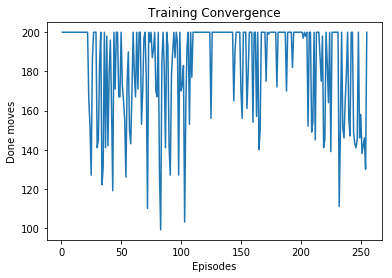

Abb 2: Anzahl der nötigen Aktionen


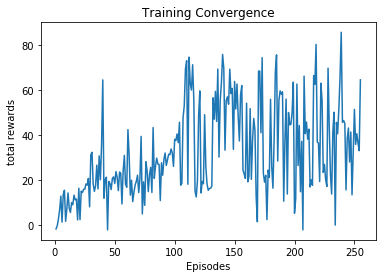

Abb 3: Eingesammelte Rewards


In [16]:
plt.plot(results[0], results[4])
plt.xlabel('Episodes')
plt.ylabel('Done moves')
plt.title('Training Convergence')
plt.show()
print("Abb 2: Anzahl der nötigen Aktionen")

plt.plot(results[0], results[3])
plt.xlabel('Episodes')
plt.ylabel('total rewards')
plt.title('Training Convergence')
plt.show()
print("Abb 3: Eingesammelte Rewards")

## Schluss
DDQN ist kein schlechtes Mittel, um einfache Aufgabenstellungen zu knacken. Natürlich gibt es hier noch etliche Methoden und Tricks, das Ergebnis zu verbessern. Man kann zum Beispiel für den Eingabevektor den aktuellen und den letzten Status verwenden, damit man auch eine Information über die Änderung der Position hat. Oder man kann in seinen Trainings Batch nur die besonders erfolgreichen Episoden aufnehmen. Irgendwann reicht das Verfahren aber nicht mehr aus und man muss sich anderen Lernverfahren wie zum Beispiel dem Actor Critic Learning zuwenden. Nichts desto trotz ist es spannend zuzusehen, wie sich der Computer ein Spiel komplett eigenständig beibringt und ich wünsche viel Spaß beim Ausprobieren.  
Abschließend noch ein kleines Beispiel von einem Modell, das im Training 104 Züge brauchte. Damit liegt es mittendrin. Mein bestes Model erreichte das Ziel in knapp 70 Zügen. 

![Abb 4: Ein ordentlich trainiertes Modell](Extended_MountainCar_model_104_loop.gif) Abb 4: Ein ordentlich trainiertes Modell